In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import os
import itertools
import re
from functools import cmp_to_key
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions

In [3]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [4]:
data = data[data["maid"]==7]

In [5]:
data["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2021, 12)         56
(2022, 1)         365
(2022, 2)          22
(2022, 12)    1329060
(2023, 1)     1402187
(2023, 2)      669026
Name: time, dtype: int64

In [6]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [7]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [8]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

In [9]:
grouped = data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [10]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [11]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [18]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536       67
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917       34

In [12]:
data.head()

,timestamp,filename,iiqid,hh_id,maid,partner_id,ip,iscellip,cellispid,domain,...,model,os,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time,is_hh
317,1672454576791,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,2935173494,True,1256337485,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-31 02:42:56.791,True
318,1672418570693,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645510743,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-30 16:42:50.693,True
319,1672278111596,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1193046921,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-29 01:41:51.596,True
320,1672186457438,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645512144,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-28 00:14:17.438,True
321,1671982417563,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645512144,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-25 15:33:37.563,True


In [13]:
grouped.lifespan.max()

84

<Axes: xlabel='lifespan', ylabel='Count'>

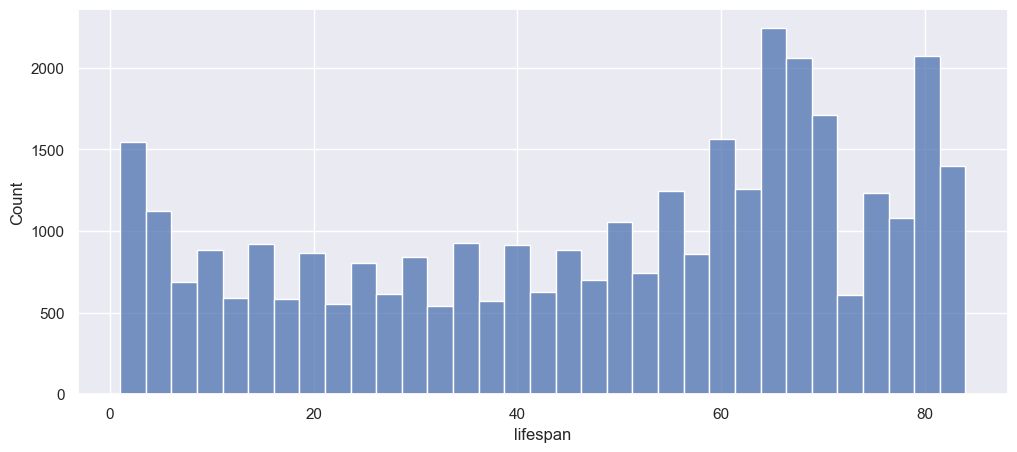

In [14]:
sns.histplot(data=grouped[grouped["lifespan"]>0], x="lifespan")
# sns.histplot(data=grouped, x="lifespan")

<BarContainer object of 2 artists>

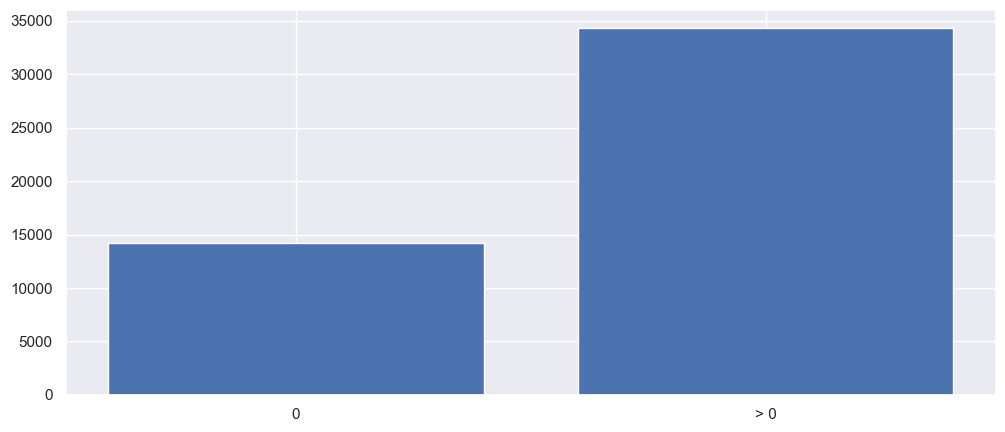

In [15]:
plt.bar(["0","> 0"], 
        [len(grouped[grouped["lifespan"]==0]), len(grouped[grouped["lifespan"]>0])])

In [16]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536       67
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917       34

In [17]:
one_row = grouped[grouped["lifespan"] > 60].sample(1)
one_row

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
pf5jEgESJa WosrCrerQi 2022-12-08 05:19:27.969 2023-02-07 14:49:18.291       61

In [90]:
one_cookie = one_row.index.get_level_values(1).values[0]

In [91]:
one_cookie

'Bcjz15r0Ms'

In [92]:
one_cookie_data = data[data["iiqid"]==one_cookie]

In [93]:
one_cookie_data.browser.value_counts()

chrome mobile    37
Name: browser, dtype: int64

In [94]:
most_common_brw = one_cookie_data.browser.mode().iloc[0]

In [95]:
one_cookie_data = one_cookie_data[one_cookie_data["browser"]==most_common_brw]

<Axes: xlabel='time', ylabel='browserversion'>

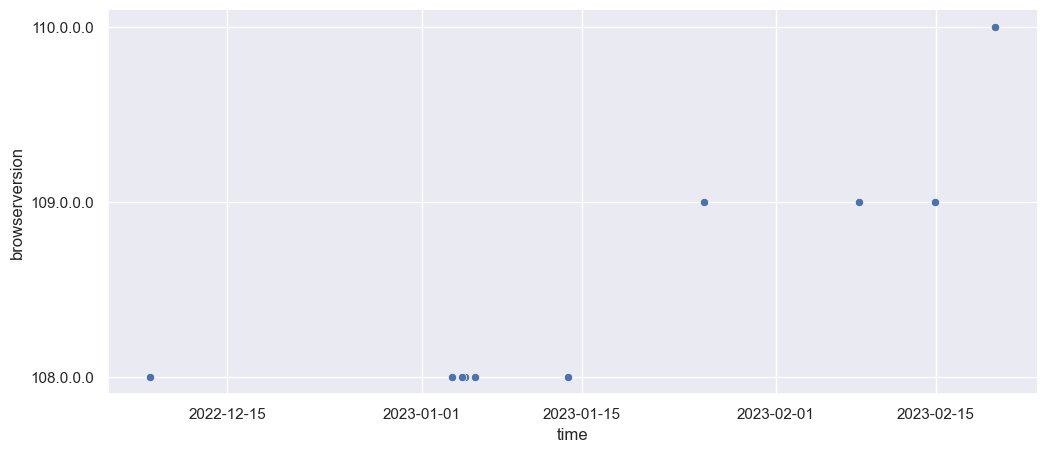

In [96]:
sns.scatterplot(data=one_cookie_data, x="time", y="browserversion")

## Lets try to find how many error are they

For a given cookie:
Go over all of its apearesnces and see if the browserversion stays consistent.
Lets strat by a simple "yes/no" test.

In [99]:
one_cookie_data = one_cookie_data.sort_values(by="time")

In [108]:
one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")

In [115]:
all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)

True

In [75]:
def has_no_errors(cookie, df=data):
    one_cookie_data = df[df["iiqid"]==cookie].sort_values(by="time")
    one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")
    one_cookie_data["prev_osversion"] = one_cookie_data["osversion"].shift(1).fillna("0")
    browser_consistency = all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)
    os_consistency = all(np.vectorize(compare_versions)(one_cookie_data['osversion'], one_cookie_data['osversion']) <= 0)
    return browser_consistency and os_consistency

In [119]:
has_no_errors(one_cookie)

True

In [19]:
data.sort_values(by="time", inplace=True)
# grouped_cookies = data.groupby(["hh_id", "iiqid"])

In [25]:
data[data['hh_id']=='1097159426'][['hh_id', 'iiqid', 'osversion']]

,hh_id,iiqid,osversion
8297176,1097159426,Ds994Aq4Kq,9
8297175,1097159426,Ds994Aq4Kq,9
8297174,1097159426,Ds994Aq4Kq,9
8297173,1097159426,Ds994Aq4Kq,9
8297172,1097159426,Ds994Aq4Kq,9
...,...,...,...
8296372,1097159426,I2g1DDxkA3,9
8296371,1097159426,I2g1DDxkA3,9
8296072,1097159426,k78WlySg6A,9
8296392,1097159426,Ds994Aq4Kq,9


In [21]:
data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1)

5305360    NaN
274574      10
5799545    NaN
1884467    NaN
6016795     10
          ... 
8296392      9
8203159     13
8296391      9
8281614     12
8281613     12
Name: osversion, Length: 3400058, dtype: object

In [26]:
data['prev_osversion'] = data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
data['prev_browserversion'] = data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [44]:
data[data['hh_id']==data['hh_id'].sample(1).values[0]].set_index(['hh_id', 'iiqid']).to_csv('temp.csv')

In [45]:
full_valid_rows = data[(np.vectorize(compare_versions)(data['osversion'], 
                                                         data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(data['browserversion'], 
                                                               data['prev_browserversion']) >= 0)]

In [46]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [47]:
total_rows_counts = data.groupby(['hh_id', 'iiqid']).size()

In [48]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [49]:
all_ok.head(10)

hh_id       iiqid     
008lj1AMI8  6MILYBoI9P    True
            UVg62Vt8Va    True
            WATS0P8zVm    True
            mXwL7QCw5O    True
            vjNRSKwlH4    True
00C30KAqMf  MkDZdCUiPK    True
017VVGbSKq  7Gqmdx5cAS    True
            9LwaJRXNWe    True
            Gc8OsRzRW1    True
            xTgngXvS70    True
dtype: bool

In [50]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

In [51]:
result

instances     ok
hh_id      iiqid                       
008lj1AMI8 6MILYBoI9P         66   True
           UVg62Vt8Va         41   True
           WATS0P8zVm        156   True
           mXwL7QCw5O         51   True
           vjNRSKwlH4         28   True
...                          ...    ...
zygR659Gbx zU35cTjEsV        595  False
zzyXvF318v 0UXCVZvWch         40  False
           26UHp1Gc7Y         46   True
           2oWL7w8Na8          2   True
           uo36TXLVcg        126  False

[48506 rows x 2 columns]

<Axes: xlabel='ok', ylabel='count'>

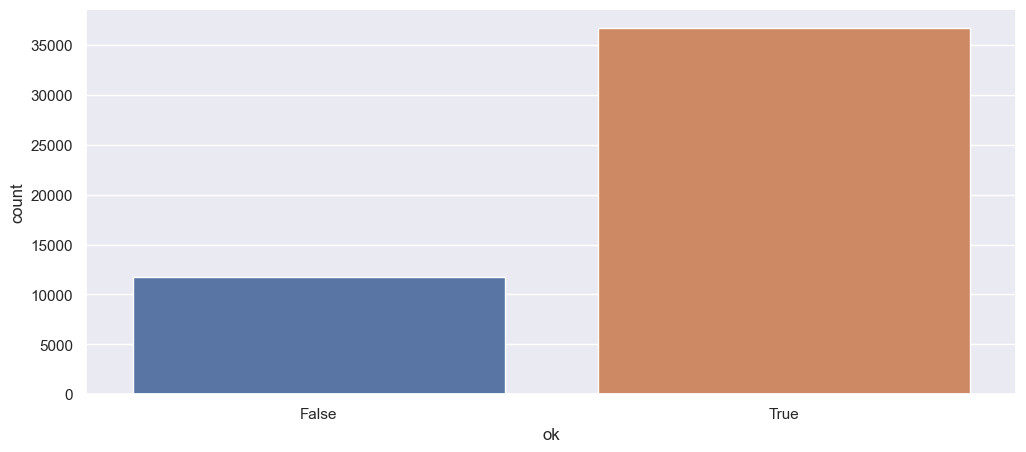

In [52]:
sns.countplot(data=result, x='ok')

In [53]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [54]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

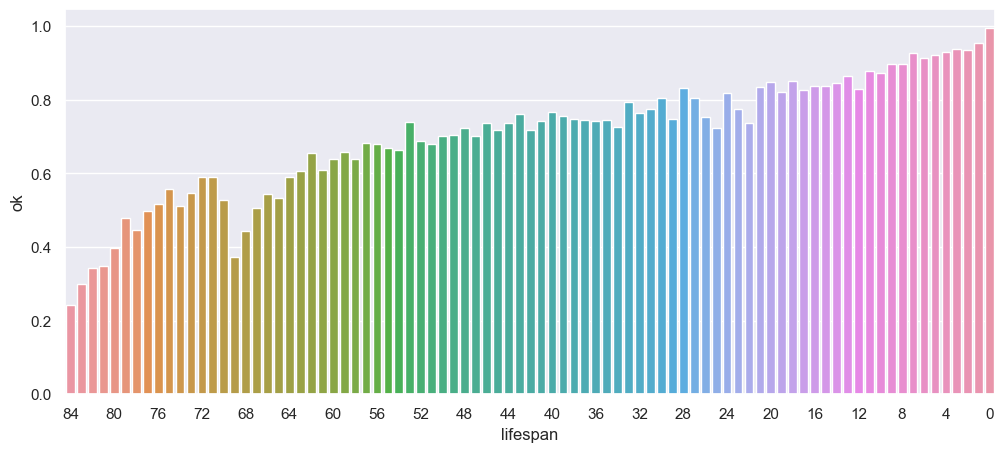

In [55]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [172]:
found = False
limit_search = 1000
while not found and limit_search > 0:
    limit_search -= 1
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id]
    # browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    browsers_of_cookie = len(one_cookie_data.browser.unique())
    os_of_cookie = len(one_cookie_data.os.unique())
    if browsers_of_cookie == 1 and os_of_cookie == 1:
        # if len(browsers_of_cookie) > 1:
        # if browsers_of_cookie.iloc[1]  > browsers_of_cookie.sum()/4:
        found = True
if found:
    print("Found!")
else:
    print("Not Found")

Found!


In [173]:
# one_cookie_data.browser

In [160]:
one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()

In [161]:
one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]

In [162]:
one_cookie_data = data[data["iiqid"]==one_cookie_id]

In [163]:
browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)

In [164]:
browsers_of_cookie.sum()/4

48.5

In [175]:
one_cookie_data.browser.value_counts()

edge    246
Name: browser, dtype: int64

In [176]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

<Axes: xlabel='time', ylabel='browserversion'>

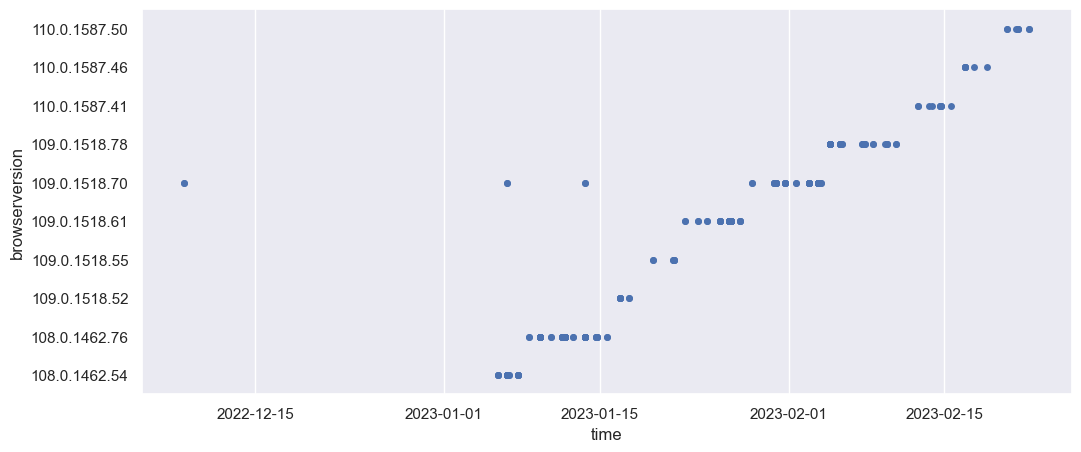

In [177]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)

In [178]:
# one_cookie_data[one_cookie_data["browserversion"].apply(lambda v: v[0]=="2")]

In [179]:
one_cookie_id

'cUO4TrcMgH'

<Axes: title={'center': "Cookie's iiqid: cUO4TrcMgH"}>

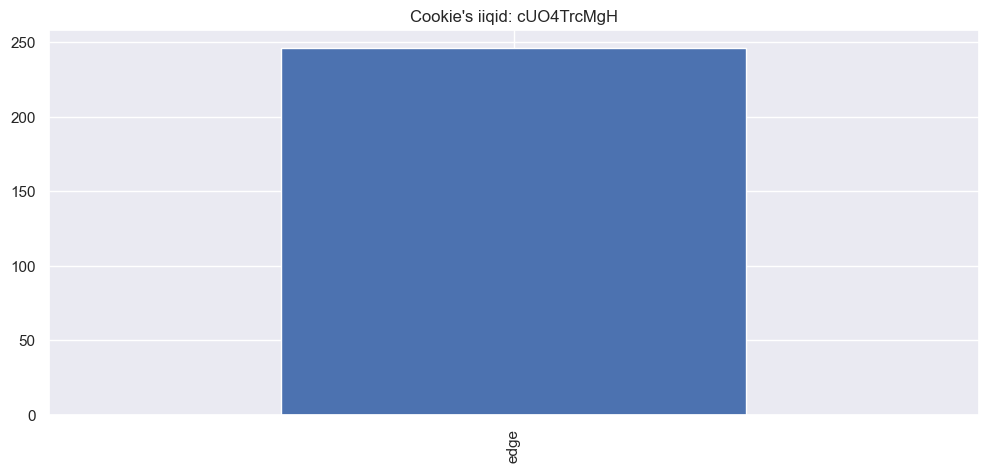

In [180]:
one_cookie_data.browser.value_counts().plot.bar(title=f"Cookie's iiqid: {one_cookie_id}")

## Mixed Constant For One Cookie

In [9]:
# data.groupby(["hh_id", "iiqid", 

In [10]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser"]].nunique()

In [11]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [12]:
equal_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]==4]
more_than_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]>4]

Text(0.5, 1.0, 'Number of user agents assosiated with each cookie')

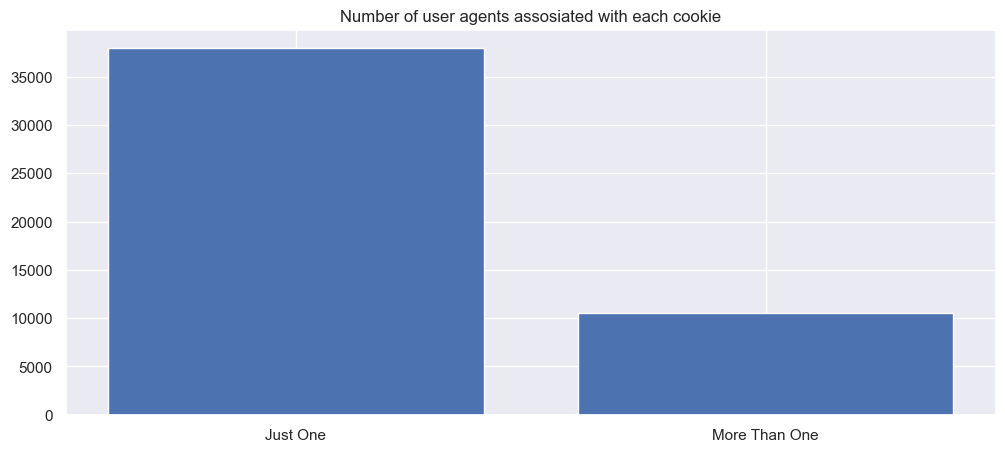

In [13]:
plt.bar(["Just One", "More Than One"], [len(equal_4), len(more_than_4)])
plt.title("Number of user agents assosiated with each cookie")

In [53]:
column_pick = "browser"
browser_counts = data.groupby(["hh_id", "iiqid"])[column_pick].value_counts()

In [54]:
unstacked_browser_counts = browser_counts.unstack(level=2).fillna(0).astype(int)

In [55]:
unstacked_browser_counts["mode"] = unstacked_browser_counts.idxmax(axis=1)

In [56]:
unstacked_browser_counts["total"] = unstacked_browser_counts.select_dtypes('number').sum(axis=1)

In [57]:
def get_value(row):
    return row[row['mode']]

unstacked_browser_counts["mode_count"] = unstacked_browser_counts.apply(get_value, axis=1)

In [58]:
unstacked_browser_counts["mode_fraction"] = unstacked_browser_counts["mode_count"] / unstacked_browser_counts["total"]

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

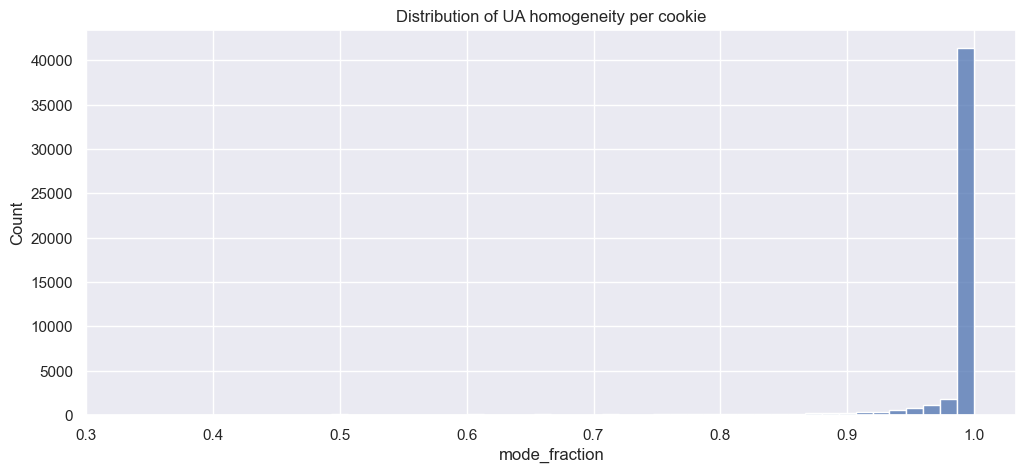

In [59]:
sns.histplot(data=unstacked_browser_counts, x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

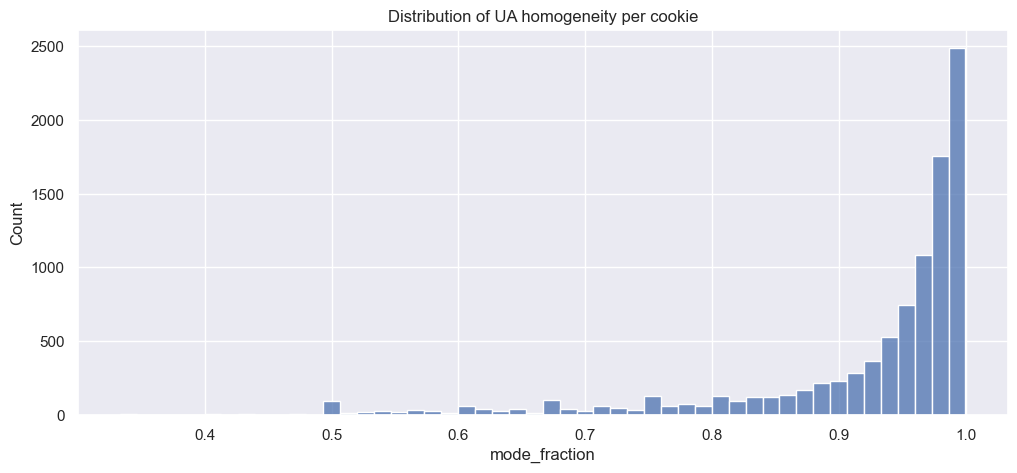

In [73]:
sns.histplot(data=unstacked_browser_counts[unstacked_browser_counts["mode_fraction"] < 1], x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

## ow many errors are they, if we exclude the mixed UA

In [97]:
non_mixed_data = data[data["iiqid"].isin(equal_4.index.get_level_values(1).to_list())]

In [99]:
non_mixed_data = non_mixed_data.sort_values(by="time")

In [100]:
non_mixed_data['prev_osversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
non_mixed_data['prev_browserversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [101]:
full_valid_rows = non_mixed_data[(np.vectorize(compare_versions)(non_mixed_data['osversion'], 
                                                         non_mixed_data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(non_mixed_data['browserversion'], 
                                                               non_mixed_data['prev_browserversion']) >= 0)]

In [102]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [103]:
total_rows_counts = non_mixed_data.groupby(['hh_id', 'iiqid']).size()

In [104]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [105]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

<Axes: xlabel='ok', ylabel='count'>

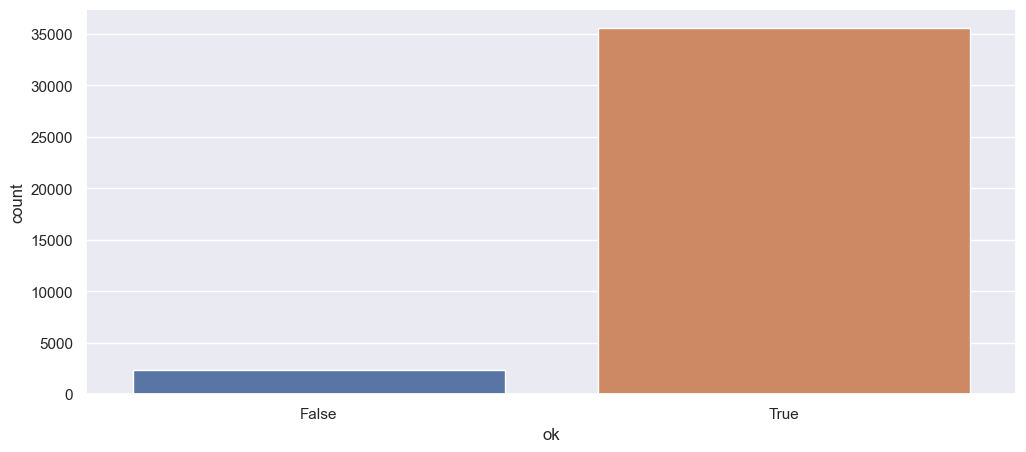

In [107]:
sns.countplot(data=result, x='ok')

In [110]:
grouped = non_mixed_data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [111]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [112]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [113]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [114]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

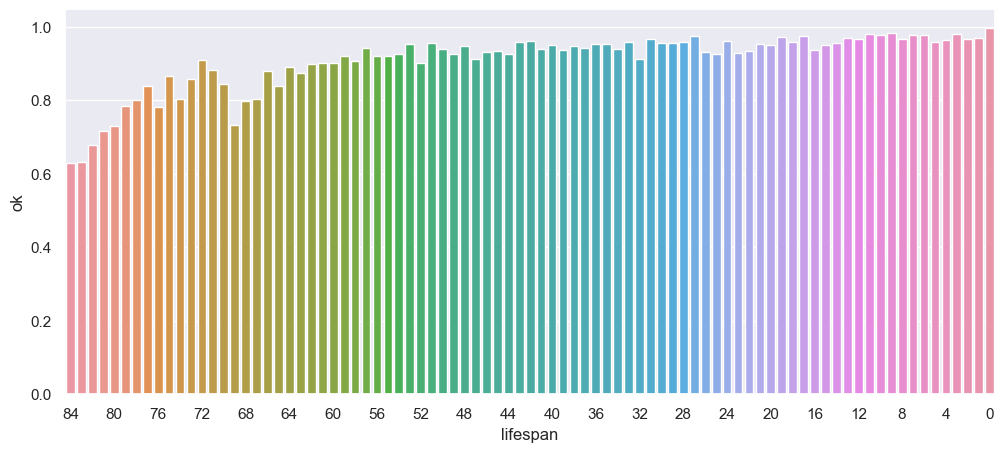

In [115]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [129]:
# cookie_hhd_data["instances"].plot.hist()
sum(cookie_hhd_data["instances"] > 500) / len(cookie_hhd_data)

0.005588064737202804

<Axes: xlabel='instances', ylabel='ok'>

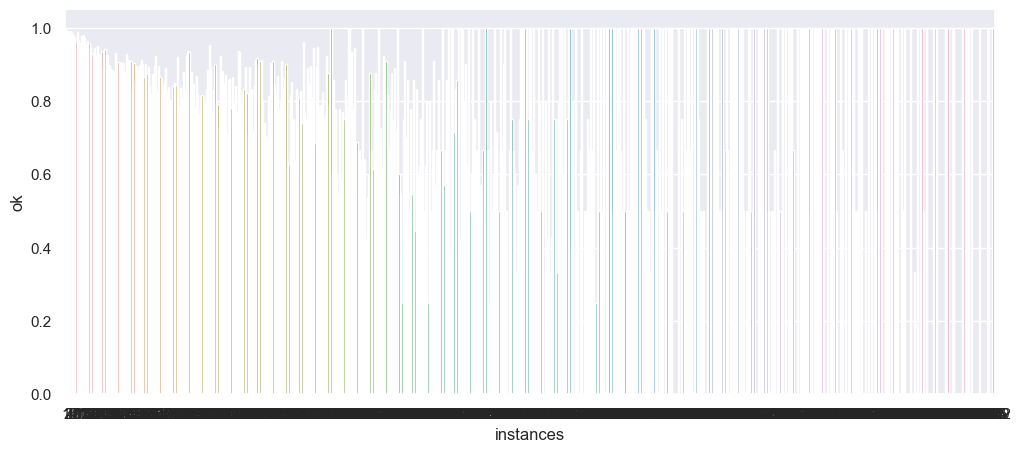

In [137]:
sns.barplot(data=cookie_hhd_data, x="instances", y="ok", errorbar=None) #, order=list(reversed(range(0, 85))))
# plt.xticks(range(0, 500, 50))
# plt.xlim(0, 500);

In [136]:
cookie_hhd_data.head()

time_min                time_max  \
hh_id      iiqid                                                        
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687   
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120   
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615   
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536   
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917   

                       lifespan  instances    ok  
hh_id      iiqid                                  
008lj1AMI8 6MILYBoI9P        58         66  True  
           UVg62Vt8Va        61         41  True  
           WATS0P8zVm        35        156  True  
           mXwL7QCw5O        67         51  True  
           vjNRSKwlH4        34         28  True

In [244]:
found = False
while not found:
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id]
    browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    if browsers_of_cookie.sum() > 25:
        if len(browsers_of_cookie) == 1:
            found = True

In [245]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

Text(0.5, 1.0, "Cookie's iiqid: uwMFDFZwoX")

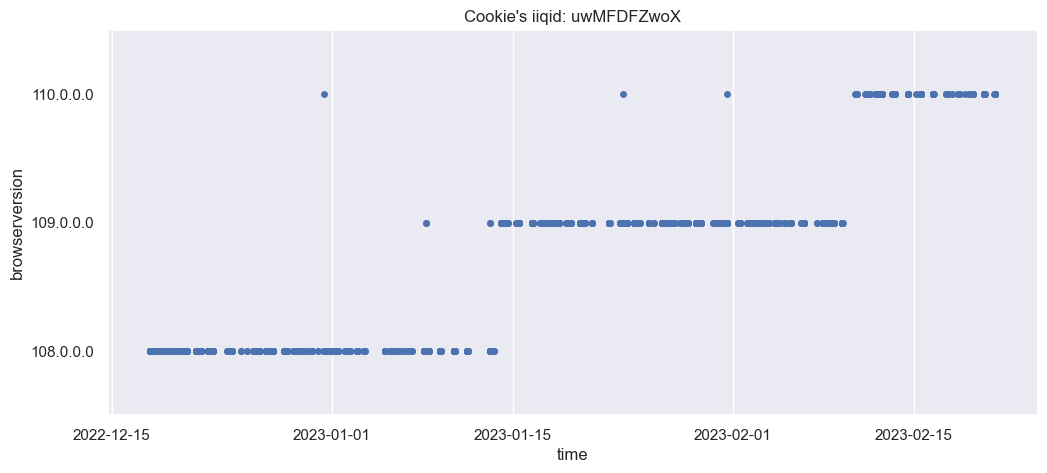

In [246]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [247]:
one_cookie_data.to_csv("another_example_for_version_noise.csv")

## Isotonic Regression

In [181]:
import sklearn as sk
from sklearn.isotonic import IsotonicRegression

In [205]:
single_example = one_cookie_data.copy()

In [206]:
ordered_versions = sorted(single_example.browserversion.unique(), key=cmp_to_key(compare_versions))

Text(0.5, 1.0, "Cookie's iiqid: cUO4TrcMgH")

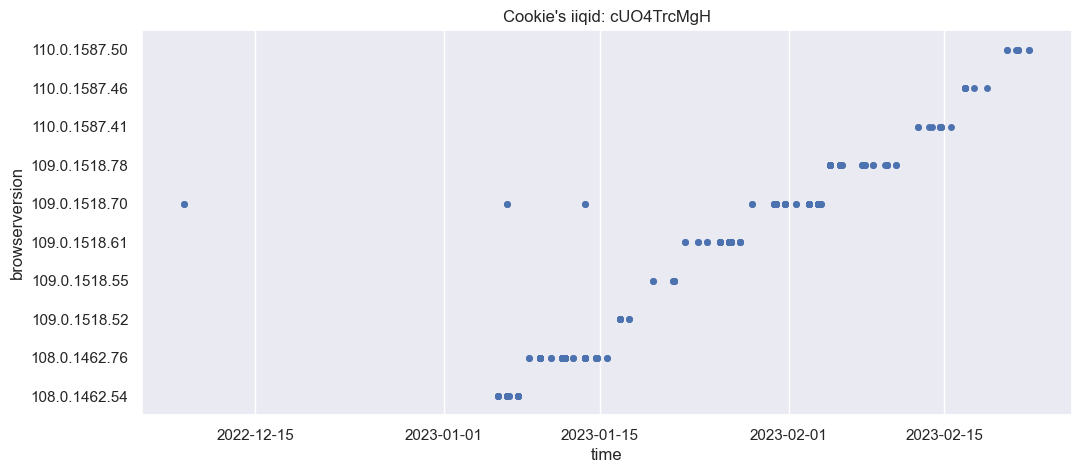

In [207]:
sns.stripplot(data=single_example, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [237]:
isotonic = IsotonicRegression() #out_of_bounds='clip')

In [196]:
serialized_browserversions = dict(enumerate(ordered_versions))

In [209]:
single_example['serial_browserversion'] = None

In [211]:
single_example['serial_browserversion'] = single_example['browserversion'].apply(lambda v: ordered_versions.index(v))

Text(0.5, 1.0, "Cookie's iiqid: cUO4TrcMgH")

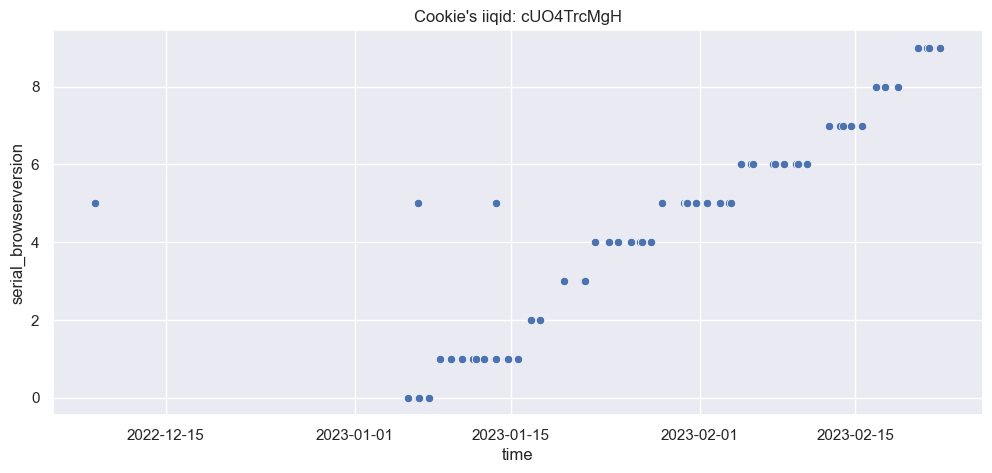

In [224]:
sns.scatterplot(data=single_example, x="time", y="serial_browserversion")#, jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [238]:
regressed_version = isotonic.fit_transform(single_example.time, single_example.serial_browserversion).round()

In [253]:
mask = np.where(single_example.serial_browserversion != regressed_version)

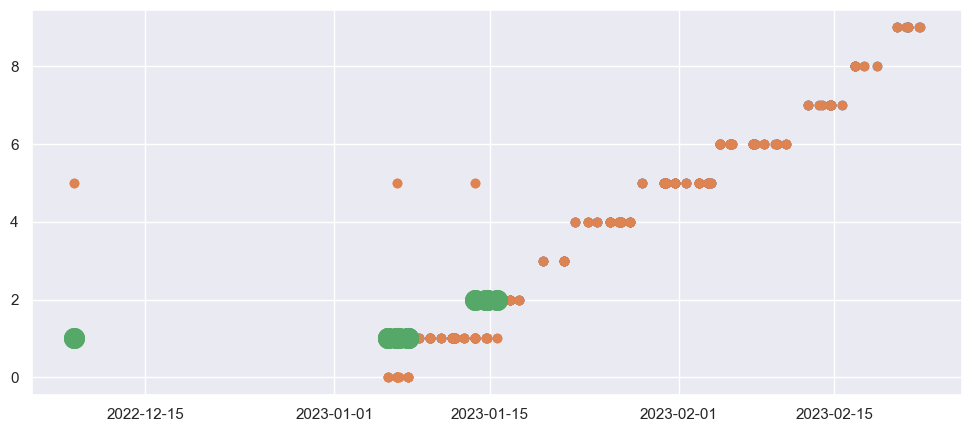

In [258]:
plt.scatter(single_example.time, regressed_version)
plt.scatter(single_example.time, single_example.serial_browserversion)
plt.scatter(single_example.time.iloc[mask], regressed_version[mask], s=200)

In [265]:
from lnds import longest_non_decreasing_subsequence as lnds

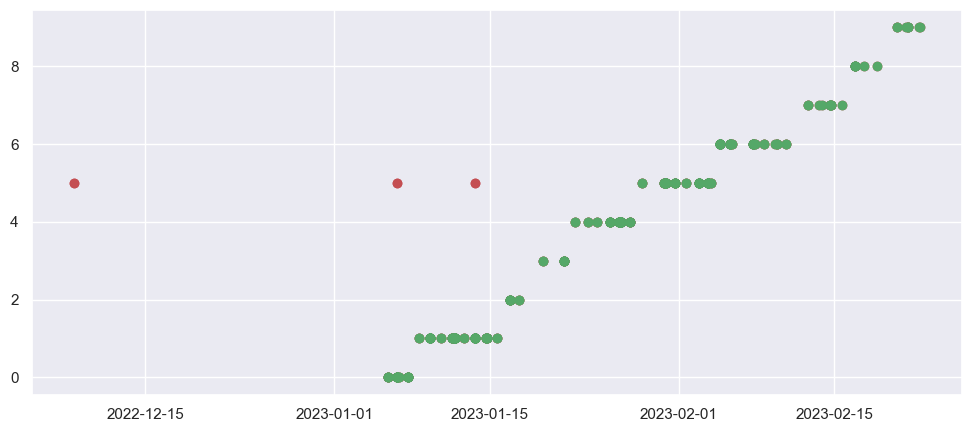

In [299]:
x, y = lnds(single_example.serial_browserversion.values)
plt.scatter(single_example.time, single_example.serial_browserversion, c='r')
plt.scatter(single_example.time.iloc[y], x, c='g')

In [301]:
len(x) / len(single_example)

0.975609756097561

In [302]:
from hard_rules import denoised_fraction

In [303]:
denoised_fraction(single_example)

0.975609756097561